In [1]:
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from numpy.linalg import inv
#from scipy.optimize import root
img1_color = cv2.imread("img_L.JPG") # Image to be aligned.
img2_color = cv2.imread("img_R.JPG") # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)




# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(50000)
#orb_detector.setMaxFeatures(10000)
# Find keypoints and descriptors.
# The first arg is the image, second arg is the mask
# (which is not required in this case).
kp1, d1 = orb_detector.detectAndCompute(img1, None)
kp2, d2 = orb_detector.detectAndCompute(img2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = matcher.match(d1, d2)
# Sort matches on the basis of their Hamming distance.
list(matches).sort(key = lambda x: x.distance)


# Take the top 90 % matches forward.
matches = matches[:int(len(matches)*0.95)]
no_of_matches = len(matches)
print("number of matches:",no_of_matches)
# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

for i in range(len(matches)):
  p1[i, :] = kp1[matches[i].queryIdx].pt
  p2[i, :] = kp2[matches[i].trainIdx].pt


p1 = np.int32(p1)
p2 = np.int32(p2)

q, mask = cv2.findFundamentalMat(p1,p2,cv2.FM_RANSAC)



# We select only inlier points
p11 = p1[mask.ravel() == 1]
p22 = p2[mask.ravel() == 1]
n = p11.shape[0]

# Create an array of shape (n, 3) with the third column filled with zeros
points1 = np.ones((n, 3))
points2 = np.ones((n, 3))

# Assign the values from the original array to the first two columns
points1[:, :2] = p11
points2[:, :2] = p22

print(points1[0:10])
print(points2[0:10])



number of matches: 6996
[[2.692e+03 6.610e+02 1.000e+00]
 [2.689e+03 6.650e+02 1.000e+00]
 [2.705e+03 6.650e+02 1.000e+00]
 [2.701e+03 6.670e+02 1.000e+00]
 [2.652e+03 6.720e+02 1.000e+00]
 [2.619e+03 6.740e+02 1.000e+00]
 [2.701e+03 6.790e+02 1.000e+00]
 [2.705e+03 6.790e+02 1.000e+00]
 [2.661e+03 6.890e+02 1.000e+00]
 [2.706e+03 6.970e+02 1.000e+00]]
[[2.186e+03 9.270e+02 1.000e+00]
 [2.182e+03 9.300e+02 1.000e+00]
 [2.196e+03 9.300e+02 1.000e+00]
 [2.193e+03 9.330e+02 1.000e+00]
 [2.148e+03 9.390e+02 1.000e+00]
 [2.119e+03 9.410e+02 1.000e+00]
 [2.193e+03 9.440e+02 1.000e+00]
 [2.196e+03 9.430e+02 1.000e+00]
 [2.156e+03 9.550e+02 1.000e+00]
 [2.196e+03 9.610e+02 1.000e+00]]


In [2]:
def compute_fundamental_matrix(points1, points2):
    '''
    Compute the fundamental matrix given the point correspondences

    Parameters
    ------------
    points1, points2 - array with shape [n, 3]
        corresponding points in images represented as
        homogeneous coordinates
    '''
    # validate points
    assert points1.shape[0] == points2.shape[0], "no. of points don't match"

    u1 = points1[0:8, 0]
    v1 = points1[0:8, 1]
    u2 = points2[0:8, 0]
    v2 = points2[0:8, 1]
    one = np.ones_like(u1)

    # construct the matrix
    # A = [u2.u1, u2.v1, u2, v2.u1, v2.v1, v2, u1, v1, 1] for all the points
    # stack columns
    A = np.c_[u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, one]

    # peform svd on A and find the minimum value of |Af|
    U, S, V = np.linalg.svd(A, full_matrices=True)
    f = V[-1, :]
    F = f.reshape(3, 3) # reshape f as a matrix

    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0 # zero out the last singular value
    F = U @ np.diag(S) @ V

    return F

In [3]:
F=compute_fundamental_matrix(points1, points2)
F

array([[ 1.97090960e-08, -7.18211397e-07,  4.06318668e-04],
       [ 7.13572776e-07,  2.31768567e-07, -2.06801352e-03],
       [-6.91055490e-04,  1.34341948e-03,  9.99996638e-01]])

In [4]:
def compute_epipole(F):
    '''
    Compute epipole using the fundamental matrix.
    pass F.T as argument to compute the other epipole
    '''
    U, S, V = np.linalg.svd(F)
    e = V[-1, :]
    e = e / e[2]
    return e

In [5]:
def findCameraMatrix(F):



# Find the right null space
  e2= compute_epipole(F.transpose())
  #o=find_epipoles(F.transpose())
  e2_hat = np.array([[0, -e2[2], e2[1]],
                    [e2[2], 0, -e2[0]],
                    [-e2[1], e2[0], 0]])
  E = e2_hat
  G=np.dot(e2_hat,F)
# Perform SVD decomposition of the essential matrix to extract R and T
  U, S, Vt = np.linalg.svd(E)

  # Ensure proper orientation of R and T
  if np.linalg.det(U) < 0:
      U *= -1
  if np.linalg.det(Vt) < 0:
      Vt *= -1

  # Reconstruct the projection matrix for the second camera (P2)
  R = np.dot(U, np.dot([[0, -1, 0], [1, 0, 0], [0, 0, 1]], Vt))
  T = U[:, 2]  # Translation vector

  # Combine R and T to form the projection matrix for the second camera (P2)
  P2 = np.column_stack((R, T))

  # print("Projection matrix for the second camera (P2):")
  # print(P2)
  P=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
  #P2=np.array([[0,-e[2],e[1],e[0]],[e[2],0,-e[0],e[1]],[-e[1],e[0],0,e[2]]])
  return e2,P,P2,G


In [6]:

e,P,P_dash,G=findCameraMatrix(F)
print(f"epipole is \n:{e}")
print(f"fundamental Matrix is \n:{F}")
print(f"Camera Matrix P is \n:{P}")
print(f"Camera Matrix P' is \n:{P_dash}")
print(f"epipole is \n:{G}")
#print(f"epipole is \n:{o}")

epipole is 
:[2.16374066e+03 9.08681131e+02 1.00000000e+00]
fundamental Matrix is 
:[[ 1.97090960e-08 -7.18211397e-07  4.06318668e-04]
 [ 7.13572776e-07  2.31768567e-07 -2.06801352e-03]
 [-6.91055490e-04  1.34341948e-03  9.99996638e-01]]
Camera Matrix P is 
:[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
Camera Matrix P' is 
:[[ 7.00152160e-01  7.13993232e-01  7.85746735e-04  9.21995705e-01]
 [ 7.13993232e-01 -7.00152523e-01  3.29980965e-04  3.87199869e-01]
 [ 7.85746735e-04  3.29980965e-04 -9.99999637e-01  4.26111928e-04]]
epipole is 
:[[-6.27949797e-01  1.22073970e+00  9.08680144e+02]
 [ 1.49526488e+00 -2.90681207e+00 -2.16373298e+03]
 [ 1.52607715e-03  1.15411222e-03 -4.84385904e+00]]


In [7]:
k,l=p1.shape
#k,l=points1.shape
p1.shape

(6996, 2)

In [8]:
X_hat=np.zeros((k,4),dtype=np.float64)
p1_hat=np.zeros((k,2),dtype=np.float64)

for i in range(0,k):
  # x1=points1[i][0]
  # y1=points1[i][1]
  # x2=points2[i][0]
  # y2=points2[i][1]
  x1=p1[i][0]
  y1=p1[i][1]
  x2=p2[i][0]
  y2=p2[i][1]
  T1=np.array([[1,0,-x1],[0,1,-y1],[0,0,1]])
  T2=np.array([[1,0,-x2],[0,1,-y2],[0,0,1]])
  F=(inv(T2.transpose()))@F@(inv(T1))

# Perform singular value decomposition
  U1, s1, V1 = np.linalg.svd(F)
  U2, s2, V2 = np.linalg.svd(F.transpose())

# Find the right null space
  e1= V1[2,:]
  e2= V2[2,:]
  print(e1)
  e1 = e1/ np.sqrt(e1[0]**2 + e1[1]**2)
  e2 = e2/ np.sqrt(e2[0]**2 + e2[1]**2)
  R1=np.array([[e1[0],e1[1],0],[-e1[1],e1[0],0],[0,0,1]])
  R2=np.array([[e2[0],e2[1],0],[-e2[1],e2[0],0],[0,0,1]])
  F=R2@F@(R1.transpose())
  f1=e1[2]
  f2=e2[2]
  a=F[1][1]
  b=F[1][2]
  c=F[2][1]
  d=F[2][2]

  #a0 = b*d*(-a*d + b*c)
  #a1 = b**4+(2*b**2)*(d**2)*(f2**2)+(d**4)*(f2**4)-(a**2)*(d**2)+(b**2)*(c**2)
  #a2 = 4*a*(b**3) + 4*a*b*(d**2)*(f2**2) + 4*(b**2)*c*d*(f2**2) + 4*c*(d**3)*(f2**4) - (a**2)*c*d + a*b*(c**2) - 2*a*b*(d**2)*(f1**2) + 2*(b**2)*c*d*(f1**2)
  #a3 = (6*(a**2)*(b**2)+2*(a**2)*(d**2)*(f2**2)+8*a*b*c*d*(f2**2)+2*(b**2)*(c**2)*(f2**2)+6*(c**2)*(d**2)*(f2**4)-2*(a**2)*(d**2)*(f1**2)+2*(b**2)*(c**2)*(f1**2))
  #a5 = (a**4 + 2*(a**2)*(c**2)*(f2**2)+(c**4)*(f2**4)-(a**2)*(d**2)+(b**2)*(c**2)*(f1**4))
  #a6 = (a*b*(c**2)*(f1**4)-(a**2)*c*d*(f1**4))
  #coeff=[a6,a5,a4,a3,a2,a1,a0]
  # Step 7: Compute the polynomial g(t)
  def g(t):
    return t * ((a * t + b)**2 + f2**2 * (c * t + d)**2)**2 - (a * d - b * c) * ((1 + f1**2 * t**2))**2 * (a * t + b) * (c * t + d)

        # Step 8: Find the roots of g(t)
  roots = np.roots([g(6), g(5), g(4), g(3), g(2), g(1), g(0)])



  #roots = np.roots([equation(6), equation(5), equation(4), equation(3), equation(2), equation(1), equation(0)])
 #roots=np.roots(coeff)
  c_t=np.ones((7))

  for j in range(0,6):
    t  = roots[j].real
    c = (t**2)/(1+(t**2)*(f1**2)) + ((c*t + d)**2)/((a*t + b)**2 + ((c*t + d)**2)*(f2**2))
    c_t[j]=c

  c_t[6]=1/(f1**2) + (c**2)/((a**2) + (f2**2)*(c**2))
  r=np.argmin(c_t)
  if(r == 6):
      ##at t == infinity
    x1_hat = 1/f1
    y1_hat = 0
    x2_hat = 1/f2
    y2_hat = 0
  else:
    t1=roots[r].real
    t2 = -(c*t + d) / (a*t + b)
    x1_hat = ((t1**2)*(f1))/(1 + (t1**2)*(f1**2))
    y1_hat = (t1)/(1 + (t1**2)*(f1**2))

    x2_hat = ((t2**2)*(f2))/(1 + (t2**2)*(f2**2))
    y2_hat = (t2)/(1 + (t2**2)*(f2**2))

  new_x1=inv(T1)@(R1.transpose())@(np.array([[x1_hat],[y1_hat],[1]]))
  new_x2=inv(T2)@(R2.transpose())@(np.array([[x2_hat],[y2_hat],[1]]))
  C=np.array([ [new_x1[0]*P[2]], [new_x1[1]*P[2]] , [new_x2[0]*P_dash[2]] , [new_x2[1]*P_dash[2]] ])
  C=np.squeeze(C)
  D=np.array([ [P[0]], [P[1]] , [P_dash[0]] , [P_dash[1]] ])
  D=np.squeeze(D)
  A=C-D
  U, s, V = np.linalg.svd(A)
  y = np.array([[0,0,0,1]],dtype=np.float64)
  y = y.transpose()

  X = V@y


  X1=X[0]/X[3]
  X2=X[1]/X[3]
  X3=X[2]/X[3]

  X_hat[i][0]=X1
  X_hat[i][1]=X2
  X_hat[i][2]=X3
  X_hat[i][3]=1

  p=new_x1[0][0]/new_x1[2][0]
  q=new_x1[1][0]/new_x1[2][0]
  p1_hat[i][0]=p
  p1_hat[i][1]=q

points=X_hat[:,:3]
points




[ 6.12282867e-01  7.90638711e-01 -3.44439758e-04]
[-9.41758850e-01 -3.36288944e-01  1.18411600e-04]
[-9.48037985e-01  3.18157141e-01 -1.13102432e-04]
[ 9.80430775e-01  1.96864142e-01 -7.14311112e-05]
[ 9.88074909e-01  1.53973927e-01 -5.65664683e-05]
[-9.99733921e-01 -2.30669548e-02  5.55830236e-05]
[ 9.82944697e-01 -1.83901380e-01  6.79857226e-05]
[ 9.71621285e-01 -2.36541901e-01  8.74785138e-05]
[-9.46631275e-01  3.22318500e-01 -1.19821004e-04]
[ 9.75373474e-01  2.20559696e-01 -8.21451382e-05]
[ 9.85714073e-01  1.68427322e-01 -6.34856094e-05]
[-9.90908938e-01 -1.34534284e-01  5.17240614e-05]
[-9.88033866e-01  1.54237075e-01 -5.96661799e-05]
[-9.92027846e-01 -1.26018847e-01  4.88445142e-05]
[-9.89221595e-01  1.46426203e-01 -5.67763485e-05]
[ 9.92775535e-01  1.19986399e-01 -4.69797959e-05]
[ 9.95086521e-01  9.90091605e-02 -3.87966930e-05]
[-9.96106953e-01 -8.81529155e-02  3.45697708e-05]
[-9.94626346e-01  1.03529851e-01 -4.06318095e-05]
[ 9.96183582e-01  8.72827024e-02 -3.42822869e-05]


C:\Users\Soumyadeep\AppData\Local\Temp\ipykernel_19908\1029951024.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_hat[i][0]=X1
C:\Users\Soumyadeep\AppData\Local\Temp\ipykernel_19908\1029951024.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_hat[i][1]=X2
C:\Users\Soumyadeep\AppData\Local\Temp\ipykernel_19908\1029951024.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_hat[i][2]=X3


[ 9.99376847e-01  3.52975627e-02 -1.51882800e-05]
[-9.99438340e-01 -3.35112530e-02  1.44320642e-05]
[-9.99412181e-01  3.42825376e-02 -1.47769558e-05]
[-9.99439560e-01 -3.34748422e-02  1.44288113e-05]
[-9.99368304e-01  3.55385967e-02 -1.53249662e-05]
[ 9.99399412e-01  3.46527835e-02 -1.49494321e-05]
[ 9.99429586e-01  3.37713274e-02 -1.45880464e-05]
[-9.99960192e-01 -8.92266133e-03  1.40514352e-05]
[ 9.99959792e-01 -8.96741499e-03  1.40775746e-05]
[-9.99470393e-01  3.25412406e-02 -1.40810214e-05]
[ 9.99522110e-01  3.09119878e-02 -1.33992145e-05]
[-9.99530311e-01 -3.06456589e-02  1.32952967e-05]
[ 9.99958684e-01 -9.09007634e-03  1.40931416e-05]
[-9.99427665e-01  3.38281159e-02 -1.46887173e-05]
[-9.99958208e-01 -9.14236665e-03  1.41303967e-05]
[-9.99953080e-01  9.68699835e-03 -1.49721767e-05]
[ 9.99435745e-01  3.35885559e-02 -1.46164299e-05]
[ 9.99501604e-01  3.15680643e-02 -1.37611440e-05]
[-9.99555688e-01 -2.98064887e-02  1.29989048e-05]
[-9.99503721e-01  3.15009688e-02 -1.37438782e-05]


array([[ 1.04706521e-10,  7.67392845e-07, -3.35847428e-06],
       [-7.06143866e-05,  8.22362306e-01,  3.90355074e-02],
       [ 1.40928240e-04, -2.91885976e-01, -5.10963805e-01],
       ...,
       [-6.94839820e-04,  7.34630151e-01, -1.05700783e+00],
       [-6.47895185e-04,  7.22549977e-01,  8.89714876e-01],
       [-6.91556422e-04,  7.33124307e-01, -1.04614757e+00]])

In [41]:
#len(p1)
# points1.size
# points.size
new_mat = np.column_stack((p1[:, :2], 1000*points[:, 2]))
threshold_x1 = 2700
threshold_x2 = 3600
threshold_y = 1500
# Filter points based on x-axis values
# filtered_indices = new_mat[:, 0] >= threshold_x1
#filtered_indices = new_mat[:, 0] <= threshold_x2
filtered_indices = (new_mat[:, 0] >= threshold_x1) & (new_mat[:, 0] < threshold_x2) & (new_mat[:,1]> threshold_y)
# Apply filtering to new_mat
new_mat = new_mat[filtered_indices]
#new_matrix = np.column_stack((points1[:, :2], points[:, 2]))
new_mat

array([[3468.        , 2722.        ,  356.12507641],
       [3533.        , 2705.        ,  348.77295653],
       [3531.        , 2690.        ,  353.41656091],
       ...,
       [2938.        , 3326.        , -218.38067766],
       [3446.        , 3399.        , -160.67687846],
       [3319.        , 3433.        ,  174.80925622]])

In [14]:
# mean_values = np.mean(new_mat, axis=0)
# std_dev_values = np.std(new_mat, axis=0)

# # Set a threshold (e.g., 3 standard deviations)
# threshold = 1.9

# # Identify and filter out outliers
# new_mat = new_mat[
#     np.all(np.abs((new_mat - mean_values) / std_dev_values) < threshold, axis=1)
# ]
# # z_threshold = -10.0
# # new_matrix = new_matrix[new_matrix[:, 2] > z_threshold]
# # z_threshold = +10.0
# # new_matrix = new_matrix[new_matrix[:, 2] < z_threshold]


# new_mat
# print(len(new_mat))

1262


In [10]:
def decompose_camera_matrix(P):
    K, RT = np.linalg.qr(np.linalg.inv(P[:, :3]))
    K /= K[2, 2]
    T = np.dot(np.linalg.inv(K), P[:, 3])
    R = np.linalg.multi_dot([RT, np.linalg.inv(K)])
    return K, R, T

# Example camera matrix (replace this with your actual camera matrix)
# P = np.array([[f, 0, cx, tx],
#               [0, f, cy, ty],
#               [0, 0, 1, tz]])

# intrinsic, rotation, translation = decompose_camera_matrix(P_dash)

# print(f"Camera Matrix KL is \n:{intrinsic}")
# print(f"Camera Matrix K is \n:{intrinsic}")
KR, rotation2, translation2 = decompose_camera_matrix(P_dash)
KL, rotation1, translation1 = decompose_camera_matrix(P)

print(f"Camera Matrix KR is \n:{KR}")
print(f"Camera Matrix KL is \n:{KL}")


Camera Matrix KR is 
:[[-7.00152414e-01  7.13993491e-01 -7.85747021e-04]
 [-7.13993491e-01 -7.00152778e-01 -3.29981085e-04]
 [-7.85747021e-04  3.29981085e-04  1.00000000e+00]]
Camera Matrix KL is 
:[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [13]:
# min_disparity =  -1
# max_disparity = 159
# num_disparity = max_disparity - min_disparity
# SADWindowSize = 5
# uniqueness = 5
# speckle_windows_size = 5
# speckle_range = 5
# P1 = 8*3*SADWindowSize**2
# P2 = 32*3*SADWindowSize**2

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

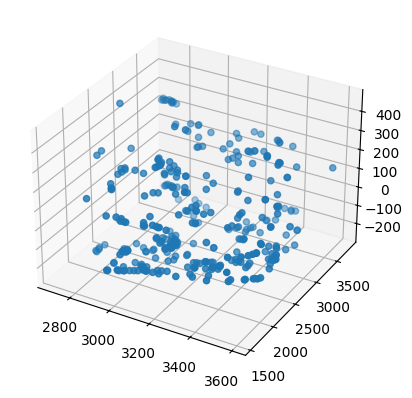

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a list of 3D points in the form of (X, Y, Z)
X, Y, Z = zip(*new_mat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z)
plt.show()


In [16]:
# #1ST METHOD


# import numpy as np
# from scipy.spatial import Delaunay
# import open3d as o3d

# # Generate random 3D points
# # np.random.seed(0)
# # points = np.random.rand(10, 3)

# # Perform Delaunay triangulation
# triangulation = Delaunay(new_mat)

# # Get the triangles from Delaunay triangulation
# triangles = points[triangulation.simplices]

# # Create an Open3D point cloud
# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(new_mat)

# # Create an Open3D mesh from the triangles
# mesh = o3d.geometry.TriangleMesh()
# mesh.vertices = o3d.utility.Vector3dVector(new_mat)
# #mesh.triangles = o3d.utility.Vector3iVector(triangulation.simplices)
# mesh.triangles = o3d.utility.Vector3iVector(triangulation.simplices[:, [0, 1, 2]])
# mesh.paint_uniform_color([0.9,0.9,0.9])
# # mesh.simplify_quadric_decimation(100000000)
# # mesh.simplify_vertex_clustering(0.0001)
# # Visualize the point cloud and mesh
# # lines = []
# # for triangle in triangulation.triangles:
# #     lines.append([triangle[0], triangle[1]])
# #     lines.append([triangle[1], triangle[2]])
# #     lines.append([triangle[2], triangle[0]])

# # line_set = o3d.geometry.LineSet()
# # line_set.points = triangulation.vertices
# # line_set.lines = o3d.utility.Vector2iVector(lines)

# # # Set visualization options
# # line_set.paint_uniform_color([0.5, 0.5, 0.5])  # Set black color for edges
# # Visualize the result
# #o3d.visualization.draw_geometries([point_cloud, line_set])
# o3d.visualization.draw_geometries([point_cloud, mesh],mesh_show_wireframe=True)


In [13]:
# import numpy as np
# from scipy.spatial import Delaunay
# import open3d as o3d

# def calculate_area(p1, p2, p3):
#     return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

# # Generate random 3D points
# # np.random.seed(0)
# # points = np.random.rand(10, 3)
# threshold=100
# # Perform Delaunay triangulation
# triangulation = Delaunay(new_mat)

# # Extract vertices and triangles
# vertices = new_mat
# triangles = vertices[triangulation.simplices]

# # Calculate areas of triangles
# areas = np.array([calculate_area(triangle[0], triangle[1], triangle[2]) for triangle in triangles])

# # Filter triangles based on area threshold
# filtered_indices = np.where(areas < threshold)[0]

# # Update triangulation.simplices
# triangulation.simplices = triangulation.simplices[filtered_indices]

# # Create LineSet geometry
# lines = []
# for simplex in triangulation.simplices:
#     simplex = np.sort(simplex)
#     lines.append([simplex[0], simplex[1]])
#     lines.append([simplex[1], simplex[2]])
#     lines.append([simplex[2], simplex[0]])

# # Create LineSet geometry
# line_set = o3d.geometry.LineSet()
# line_set.points = o3d.utility.Vector3dVector(vertices)
# line_set.lines = o3d.utility.Vector2iVector(lines)
# line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 1.0, 1.0], (len(lines), 1)))  # Set edge color to white
# line_set.paint_uniform_color([1.0, 1.0, 1.0])
# # Set visualization parameters
# visualizer = o3d.visualization.Visualizer()
# visualizer.create_window()
# visualizer.add_geometry(line_set)
# visualizer.get_render_option().point_size = 20  # Increase point size for bold points
# visualizer.get_render_option().show_coordinate_frame = False  # Hide coordinate frame for better view
# visualizer.get_render_option().background_color = np.asarray([0, 0, 0])  # Set background color to black

# # Run visualizer
# visualizer.run()
# visualizer.destroy_window()


In [42]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_mat)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [45]:
#Prime Method
import numpy as np
from scipy.spatial import Delaunay
import open3d as o3d

# Generate random 3D points (replace with your actual data)

# points = np.random.rand(10, 3)
threshold = 1.0

# Perform Delaunay triangulation
triangulation = Delaunay(new_mat)

# Filter triangles based on edge lengths
filtered_indices = []
for i, triangle in enumerate(triangulation.simplices):
  # Calculate edge lengths
  edges = points[triangle]
  edge_lengths = np.linalg.norm(edges[1:] - edges[:-1], axis=1)

  # Check if any edge exceeds the threshold
  if not np.any(edge_lengths > threshold):
    filtered_indices.append(i)

# Extract filtered points and triangles
# filtered_points = points[triangulation.vertices[filtered_indices]]
# filtered_points = points[triangulation.input[filtered_indices]]
filtered_triangles = triangulation.simplices[filtered_indices]

# Create an Open3D point cloud and line set
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(new_mat)

lines = []
for simplex in filtered_triangles:
  lines.append([simplex[0], simplex[1]])
  lines.append([simplex[1], simplex[2]])
  lines.append([simplex[2], simplex[0]])

line_set = o3d.geometry.LineSet()
line_set.points = point_cloud.points
line_set.lines = o3d.utility.Vector2iVector(lines)
line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 0.0, 0.0], (len(lines), 1)))  # Bold red color

# Configure visualization
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(point_cloud)
visualizer.add_geometry(line_set)
visualizer.get_render_option().point_size = 4
visualizer.get_render_option().show_coordinate_frame = False
visualizer.get_render_option().background_color = np.asarray([0, 0, 0])
visualizer.run()
visualizer.destroy_window()

In [32]:
# #2ND METHOD

# import numpy as np
# from scipy.spatial import Delaunay
# import open3d as o3d

# # Generate random 3D points
# # np.random.seed(0)
# # points = np.random.rand(10, 3)
# # def calculate_area(p1, p2, p3):
# #     return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))
# # Perform Delaunay triangulation
# triangulation = Delaunay(new_mat)

# # Create an Open3D point cloud
# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(new_mat)

# # Set visualization parameters
# visualizer = o3d.visualization.Visualizer()
# visualizer.create_window()
# visualizer.add_geometry(point_cloud)

# # Extract edges of the triangulated triangles
# lines = []
# for simplex in triangulation.simplices:
#     simplex = np.sort(simplex)
#     lines.append([simplex[0], simplex[1]])
#     lines.append([simplex[1], simplex[2]])
#     lines.append([simplex[2], simplex[0]])

# # Create LineSet geometry
# line_set = o3d.geometry.LineSet()
# line_set.points = o3d.utility.Vector3dVector(new_mat)
# line_set.lines = o3d.utility.Vector2iVector(lines)
# line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 0.0, 0.0], (len(lines), 1)))  # Bold red color for edges
# line_set.paint_uniform_color([1.0, 1.0, 1.0])  # Set color for points

# # Add LineSet to visualizer
# visualizer.add_geometry(line_set)

# # Set visualization parameters
# visualizer.get_render_option().point_size = 10  # Set point size for spheres
# visualizer.get_render_option().show_coordinate_frame = False  # Hide coordinate frame for better view
# visualizer.get_render_option().background_color = np.asarray([0, 0, 0])  # Set background color to black
# # Run visualizer
# visualizer.run()
# visualizer.destroy_window()


In [46]:
#2ND METHOD

import numpy as np
from scipy.spatial import ConvexHull
import open3d as o3d

# Generate random 3D points
# np.random.seed(0)
# points = np.random.rand(10, 3)
# def calculate_area(p1, p2, p3):
#     return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))
# Perform Delaunay triangulation
triangulation = ConvexHull(new_mat)

# Create an Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(new_mat)

# Set visualization parameters
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()
visualizer.add_geometry(point_cloud)

# Extract edges of the triangulated triangles
lines = []
for simplex in triangulation.simplices:
    simplex = np.sort(simplex)
    lines.append([simplex[0], simplex[1]])
    lines.append([simplex[1], simplex[2]])
    lines.append([simplex[2], simplex[0]])

# Create LineSet geometry
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(new_mat)
line_set.lines = o3d.utility.Vector2iVector(lines)
line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 0.0, 0.0], (len(lines), 1)))  # Bold red color for edges
line_set.paint_uniform_color([1.0, 1.0, 1.0])  # Set color for points

# Add LineSet to visualizer
visualizer.add_geometry(line_set)

# Set visualization parameters
visualizer.get_render_option().point_size = 5  # Set point size for spheres
visualizer.get_render_option().show_coordinate_frame = False  # Hide coordinate frame for better view
visualizer.get_render_option().background_color = np.asarray([0, 0, 0])  # Set background color to black
# Run visualizer
visualizer.run()
visualizer.destroy_window()


In [19]:
# import numpy as np
# from scipy.spatial import Delaunay
# import open3d as o3d

# def calculate_angle(p1, p2, p3):
#     v1 = p1 - p2
#     v2 = p3 - p2
#     dot_product = np.dot(v1, v2)
#     norms = np.linalg.norm(v1) * np.linalg.norm(v2)
#     angle = np.arccos(dot_product / norms)
#     return np.degrees(angle)

# # Generate random 3D points
# # np.random.seed(0)
# # points = np.random.rand(10, 3)

# # Perform Delaunay triangulation
# triangulation = Delaunay(new_mat)

# # Extract vertices and triangles
# vertices = new_mat
# triangles = vertices[triangulation.simplices]

# # Filter triangles based on angle threshold
# angles = []
# filtered_triangles = []
# for triangle in triangles:
#     angle1 = calculate_angle(triangle[0], triangle[1], triangle[2])
#     angle2 = calculate_angle(triangle[1], triangle[2], triangle[0])
#     angle3 = calculate_angle(triangle[2], triangle[0], triangle[1])
#     if angle1 >= 25 and angle2 >= 25 and angle3 >= 25:
#         filtered_triangles.append(triangle)

# # Create lines from the filtered triangles
# lines = []
# for triangle in filtered_triangles:
#     lines.extend([[triangle[0], triangle[1]], [triangle[1], triangle[2]], [triangle[2], triangle[0]]])

# # # Create LineSet geometry
# # line_set = o3d.geometry.LineSet()
# # line_set.points = o3d.utility.Vector3dVector(vertices)
# # line_set.lines = o3d.utility.Vector2iVector(lines)
# # line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 1.0, 1.0], (len(lines), 1)))  # Set edge color to white

# # # Set visualization parameters
# # visualizer = o3d.visualization.Visualizer()
# # visualizer.create_window()
# # visualizer.add_geometry(line_set)
# # visualizer.get_render_option().point_size = 5  # Increase point size for bold points
# # visualizer.get_render_option().show_coordinate_frame = False  # Hide coordinate frame for better view
# # visualizer.get_render_option().background_color = np.asarray([0, 0, 0])  # Set background color to black

# # # Run visualizer
# # visualizer.run()
# # visualizer.destroy_window()
# point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(new_mat)

# # Set visualization parameters
# visualizer = o3d.visualization.Visualizer()
# visualizer.create_window()
# visualizer.add_geometry(point_cloud)

# line_set = o3d.geometry.LineSet()
# line_set.points = o3d.utility.Vector3dVector(new_mat)
# line_set.lines = o3d.utility.Vector2iVector(lines)
# line_set.colors = o3d.utility.Vector3dVector(np.tile([1.0, 0.0, 0.0], (len(lines), 1)))  # Bold red color for edges
# line_set.paint_uniform_color([1.0, 1.0, 1.0])  # Set color for points

# # Add LineSet to visualizer
# visualizer.add_geometry(line_set)

# # Set visualization parameters
# visualizer.get_render_option().point_size = 10  # Set point size for spheres
# visualizer.get_render_option().show_coordinate_frame = False  # Hide coordinate frame for better view
# visualizer.get_render_option().background_color = np.asarray([0, 0, 0])  # Set background color to black
# # Run visualizer
# visualizer.run()
# visualizer.destroy_window()


In [18]:
# import numpy as np
# from scipy.spatial import Delaunay
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# # Generate random 3D points


# # Perform Delaunay triangulation
# triangulation = Delaunay(new_mat)

In [20]:
# import open3d as o3d
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(new_mat)

# # Visualize the point cloud
# o3d.visualization.draw_geometries([pcd])

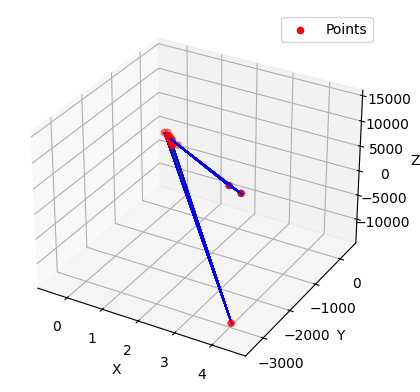

In [28]:
# import numpy as np
# from scipy.spatial import Delaunay
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# # Generate random 3D points


# # Perform Delaunay triangulation
# triangulation = Delaunay(new_matrix)

# # Plot the 3D points
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', label='Points')

# # Plot the Delaunay triangulation
# for simplex in triangulation.simplices:
#     simplex_points = points[simplex]
#     poly3d = Poly3DCollection([simplex_points], edgecolor='b', facecolors='g', alpha=0.1)
#     ax.add_collection3d(poly3d)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.legend()

# Show the plot
#plt.show()
